In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from snowflake.connector.pandas_tools import write_pandas
from sqlalchemy import create_engine
import snowflake.connector

d:\Users\ksbha\miniconda3\envs\footy\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (14.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


In [2]:
import snowflake.connector

In [3]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [4]:
SNOWFLAKE_USER = 'kbharaj3'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'qx25653.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'FOOTY_STORE'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [5]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [6]:
cursor = conn.cursor()

In [7]:
def fetch_data(cursor, query):
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows, columns=column_names)

In [8]:
team_names = fetch_data(cursor, 'SELECT * FROM TEAMS')

In [9]:
team_defending = fetch_data(cursor, 'SELECT * FROM TEAM_DEFENDING_STATS')

In [10]:
df_matches = fetch_data(cursor, 'SELECT * FROM MATCHES')

In [18]:
df_player_match = fetch_data(cursor, 'SELECT PLAYER_WS_ID, MATCH_ID, PLAYER_FBREF_NAME, TEAM_FBREF_ID, \
                             STARTING_POSITION_WS FROM PLAYER_MATCH')

In [12]:
df_events = fetch_data(cursor, 'SELECT * FROM EVENTS_SPADL')

In [13]:
filtered_matches = df_matches[df_matches['SEASON'] == 2223]

In [14]:
df_events = df_events.merge(filtered_matches[['MATCH_ID']], on='MATCH_ID')

In [15]:
defensive_events = df_events[df_events['TYPE_NAME'].isin(['tackle', 'foul', 'interception','clearance'])]

In [16]:
defensive_events = defensive_events[defensive_events['MATCH_ID'].isin(list(filtered_matches.MATCH_ID))]

In [17]:
# df_player_match = df_player_match[['PLAYER_WS_ID', 'MATCH_ID', 'PLAYER_FBREF_NAME', 'TEAM_FBREF_ID','STARTING_POSITION_WS']]

In [19]:
defensive_events = defensive_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on='TEAM_FBREF_ID')

In [20]:
defensive_events = defensive_events.merge(df_player_match, on=['PLAYER_WS_ID', 'MATCH_ID'])

In [21]:
interest_pos = ['DL', 'DC', 'DR']

In [22]:
defender_defend_actions = defensive_events[defensive_events['STARTING_POSITION_WS'].isin(interest_pos)]

In [23]:
# defender_defend_actions = defender_defend_actions[defender_defend_actions['START_X'] < 70]

In [24]:
grouped_def = defender_defend_actions[['TEAM_NAME','START_X']].groupby(['TEAM_NAME']).mean()

In [24]:
team_defending = team_defending.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on='TEAM_FBREF_ID')

In [25]:
grouped_OPPDA = team_defending[['TEAM_NAME','OPP_PPDA']].groupby(['TEAM_NAME']).mean()

In [26]:
grouped_def.rename({'START_X':'AVERAGE DEFNSIVE ACTION FROM DEFENDERS (YARDS)'}, axis=1,inplace=True)

In [27]:
merged_df = pd.merge(grouped_def, grouped_OPPDA, on='TEAM_NAME')

In [28]:
import matplotlib.pyplot as plt

In [29]:
merged_df.reset_index(inplace=True)

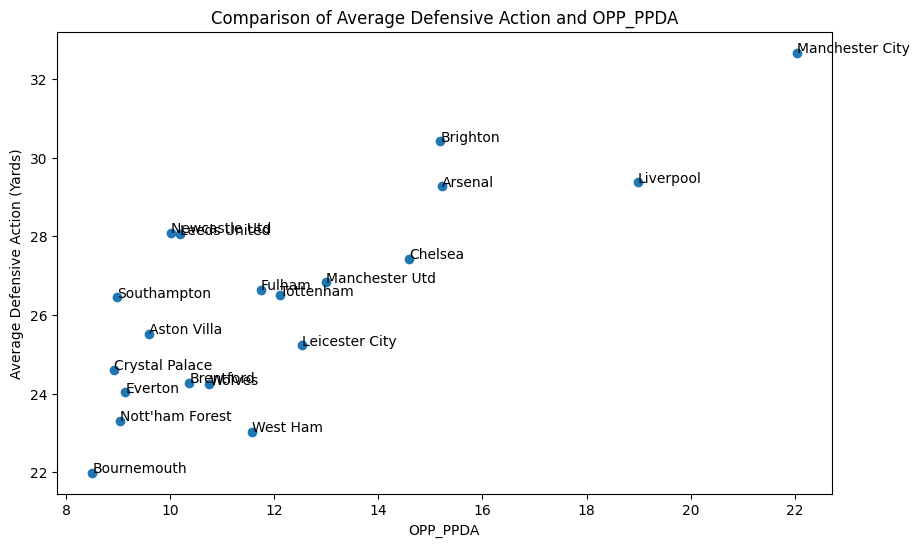

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['OPP_PPDA'], merged_df['AVERAGE DEFNSIVE ACTION FROM DEFENDERS (YARDS)'])

# Label each point
for i, team in enumerate(merged_df['TEAM_NAME']):
    plt.text(merged_df['OPP_PPDA'][i], merged_df['AVERAGE DEFNSIVE ACTION FROM DEFENDERS (YARDS)'][i], team)

plt.xlabel('OPP_PPDA')
plt.ylabel('Average Defensive Action (Yards)')
plt.title('Comparison of Average Defensive Action and OPP_PPDA')
plt.show()

In [31]:
set_piece_cross_events = df_events[df_events['TYPE_NAME'].isin(['freekick_crossed', 'corner_crossed'])]

In [32]:
set_piece_cross_events['OPPO_TEAM_ID'] = "NaN"

C:\Users\ksbha\AppData\Local\Temp\ipykernel_8552\2992158283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_piece_cross_events['OPPO_TEAM_ID'] = "NaN"


In [33]:
set_piece_cross_events

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,START_X,END_X,START_Y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,OPPO_TEAM_ID
152,b513d9fe,2.449382e+09,1,740.0,b8fd03ef,331254,72.870,90.930,63.512,39.780,0,201,freekick_crossed,foot_left,NaN
307,b513d9fe,2.449396e+09,1,2048.0,b8fd03ef,73084,90.195,100.590,56.916,32.504,0,502,freekick_crossed,foot_right,NaN
472,b513d9fe,2.449408e+09,1,2929.0,b8fd03ef,73084,91.770,97.020,5.984,37.740,1,740,freekick_crossed,foot_right,NaN
546,b513d9fe,2.449427e+09,2,920.0,b8fd03ef,73084,104.685,96.705,0.272,28.084,1,843,corner_crossed,foot_right,NaN
588,b513d9fe,2.449430e+09,2,1174.0,b8fd03ef,331254,104.475,96.390,67.660,36.312,1,918,corner_crossed,foot_left,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567685,a107c037,2.448561e+09,2,1864.0,cd051869,353377,104.475,96.915,0.340,25.228,1,962,corner_crossed,foot_left,NaN
568571,3dce3a24,2.516658e+09,2,3013.0,fd962109,243254,104.475,101.955,67.660,34.068,0,1199,corner_crossed,foot_right,NaN
568685,3dce3a24,2.516598e+09,1,328.0,cd051869,339674,104.475,93.870,0.340,38.556,0,75,corner_crossed,foot_right,NaN
568852,3dce3a24,2.516627e+09,1,2609.0,cd051869,353377,104.475,96.705,0.340,31.688,1,604,corner_crossed,foot_left,NaN


In [34]:
def swap_team_id(row, home_id, away_id):
    if row['TEAM_FBREF_ID'] == home_id:
        return away_id
    elif row['TEAM_FBREF_ID'] == away_id:
        return home_id
    else:
        return "PROBLEM"

In [35]:
for index, row in filtered_matches.iterrows():
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['AWAY_TEAM_ID']
    
    inds_to_replace = set_piece_cross_events[set_piece_cross_events['MATCH_ID'] == row['MATCH_ID']].index
    set_piece_cross_events.loc[inds_to_replace, 'OPPO_TEAM_ID'] = set_piece_cross_events.loc[inds_to_replace].apply(swap_team_id, axis=1, args=(home_team_id, away_team_id))

In [36]:
team_names_2 = team_names[['TEAM_NAME', 'TEAM_FBREF_ID']].copy()

In [37]:
team_names_2.rename({'TEAM_FBREF_ID':'OPPO_TEAM_ID'}, axis=1, inplace=True)

In [38]:
set_piece_cross_events = set_piece_cross_events.merge(team_names_2, on="OPPO_TEAM_ID")

In [39]:
set_piece_cross_events_grouped = set_piece_cross_events[['TEAM_NAME', 'MATCH_ID']].groupby(['TEAM_NAME']).count()

In [40]:
team_standard = fetch_data(cursor, 'SELECT * FROM TEAM_STANDARD_STATS')

In [41]:
team_standard = team_standard[team_standard['SEASON'] == 2223]

In [42]:
team_standard = team_standard[['TEAM_FBREF_ID', 'MATCHES_PLAYED']].merge(team_names[['TEAM_NAME','TEAM_FBREF_ID']], on='TEAM_FBREF_ID')

In [43]:
set_piece_cross_events_grouped.rename({'MATCH_ID':'OPPO CROSSES FROM SET PIECES'}, axis=1, inplace=True)

In [44]:
set_piece_cross_events_grouped = set_piece_cross_events_grouped.merge(team_standard[['TEAM_NAME', 'MATCHES_PLAYED']], on='TEAM_NAME')

In [45]:
set_piece_cross_events_grouped['OPPO CROSSES FROM SET PIECES PER GAME'] = set_piece_cross_events_grouped['OPPO CROSSES FROM SET PIECES'] / \
                                                                        set_piece_cross_events_grouped['MATCHES_PLAYED']

In [46]:
set_piece_cross_events_grouped

,TEAM_NAME,OPPO CROSSES FROM SET PIECES,MATCHES_PLAYED,OPPO CROSSES FROM SET PIECES PER GAME
0,Arsenal,175,38,4.605263
1,Aston Villa,235,38,6.184211
2,Bournemouth,265,38,6.973684
3,Brentford,214,38,5.631579
4,Brighton,158,38,4.157895
5,Chelsea,197,38,5.184211
6,Crystal Palace,205,38,5.394737
7,Everton,209,38,5.500000
8,Fulham,210,38,5.526316
9,Leeds United,220,38,5.789474


Now let's get the Y-axis for shots

In [47]:
df_shots = fetch_data(cursor, 'SELECT * FROM SHOT_EVENTS')

In [48]:
df_shots['SCA_1_PLAYER_FBREF_EVENT'].value_counts()

SCA_1_PLAYER_FBREF_EVENT
Pass (Live)     16302
Pass (Dead)      2770
Shot             1813
Take-On          1344
Fouled           1303
Tackle            176
Interception       65
nan                 6
Name: count, dtype: int64

In [49]:
df_shots['SCA_2_PLAYER_FBREF_EVENT'].value_counts()

SCA_2_PLAYER_FBREF_EVENT
Pass (Live)     15271
Take-On          1149
Shot             1066
Pass (Dead)       935
Fouled            882
Tackle            265
Interception      203
nan                 6
Name: count, dtype: int64

In [50]:
inds1 = df_shots[df_shots['SCA_1_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index

In [51]:
inds2 = df_shots[df_shots['SCA_2_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index

In [52]:
## Below, all come from a dead-ball situation
inds_union = np.union1d(inds1, inds2)

In [53]:
df_shots_set_piece = df_shots.loc[inds_union]

In [54]:
df_shots_set_piece = df_events[['MATCH_ID','ACTION_ID','TEAM_FBREF_ID']].merge(df_shots_set_piece, on=['MATCH_ID', 'ACTION_ID'])

In [55]:
df_events[['MATCH_ID','ACTION_ID','TEAM_FBREF_ID']].merge(df_shots_set_piece, on=['MATCH_ID', 'ACTION_ID'], how='inner')

,MATCH_ID,ACTION_ID,TEAM_FBREF_ID_x,TEAM_FBREF_ID_y,XG,PSXG,OUTCOME,DISTANCE,BODY_PART,NOTES,SCA_1_PLAYER_WS_ID,SCA_1_PLAYER_FBREF_EVENT,SCA_2_PLAYER_WS_ID,SCA_2_PLAYER_FBREF_EVENT
0,b513d9fe,741,b8fd03ef,b8fd03ef,0.17,NaN,Off Target,9,Head,None,73084.0,Pass (Dead),136741.0,Fouled
1,b513d9fe,919,b8fd03ef,b8fd03ef,0.11,0.03,Saved,9,Head,None,331254.0,Pass (Dead),128967.0,Pass (Live)
2,b513d9fe,429,b2b47a98,b2b47a98,0.47,0.23,Saved,6,Left Foot,Volley,379732.0,Pass (Live),83078.0,Pass (Dead)
3,b513d9fe,1228,b2b47a98,b2b47a98,0.03,NaN,Off Target,13,Left Foot,Volley,82277.0,Pass (Live),83078.0,Pass (Dead)
4,18fcd595,70,b8fd03ef,b8fd03ef,0.07,0.16,Goal,6,Head,None,104749.0,Pass (Dead),313171.0,Pass (Live)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,a107c037,908,cd051869,cd051869,0.17,NaN,Off Target,4,Head,None,353377.0,Pass (Dead),353377.0,Pass (Live)
1439,a107c037,963,cd051869,cd051869,0.01,NaN,Off Target,10,Head,None,353377.0,Pass (Dead),94935.0,Pass (Live)
1440,3dce3a24,39,cd051869,cd051869,0.38,NaN,Off Target,4,Right Foot,None,229562.0,Pass (Live),339674.0,Pass (Dead)
1441,3dce3a24,605,cd051869,cd051869,0.10,NaN,Off Target,9,Head,None,353377.0,Pass (Dead),339674.0,Pass (Dead)


In [56]:
df_shots_set_piece['OPPO_TEAM_ID'] = "NaN"

In [57]:
for index, row in filtered_matches.iterrows():
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['AWAY_TEAM_ID']
    
    inds_to_replace = df_shots_set_piece[df_shots_set_piece['MATCH_ID'] == row['MATCH_ID']].index
    df_shots_set_piece.loc[inds_to_replace, 'OPPO_TEAM_ID'] = df_shots_set_piece.loc[inds_to_replace].apply(swap_team_id, axis=1, args=(home_team_id, away_team_id))

In [58]:
df_shots_set_piece = df_shots_set_piece.merge(team_names_2, on="OPPO_TEAM_ID")

In [59]:
df_shots_set_piece_xG_group = df_shots_set_piece[['TEAM_NAME', 'XG']].groupby(['TEAM_NAME']).sum()

In [60]:
df_shots_set_piece_xG_group = df_shots_set_piece_xG_group.merge(team_standard[['TEAM_NAME', 'MATCHES_PLAYED']], on='TEAM_NAME')

In [61]:
df_shots_set_piece_xG_group['OPPO XG FROM SET PIECES PER GAME'] = df_shots_set_piece_xG_group['XG'] / \
                                                                        df_shots_set_piece_xG_group['MATCHES_PLAYED']

In [62]:
df_merged_2 = set_piece_cross_events_grouped[['TEAM_NAME', 'OPPO CROSSES FROM SET PIECES PER GAME']].merge(
    df_shots_set_piece_xG_group[['TEAM_NAME', 'OPPO XG FROM SET PIECES PER GAME']], on='TEAM_NAME'
)

In [63]:
df_merged_2.head()

,TEAM_NAME,OPPO CROSSES FROM SET PIECES PER GAME,OPPO XG FROM SET PIECES PER GAME
0,Arsenal,4.605263,0.169737
1,Aston Villa,6.184211,0.191579
2,Bournemouth,6.973684,0.268158
3,Brentford,5.631579,0.127632
4,Brighton,4.157895,0.144474


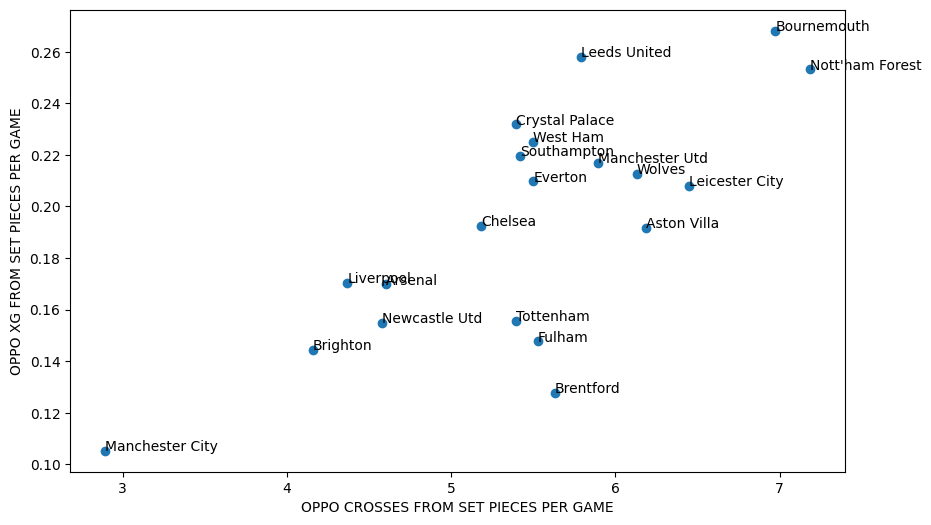

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(df_merged_2['OPPO CROSSES FROM SET PIECES PER GAME'], df_merged_2['OPPO XG FROM SET PIECES PER GAME'])

# Label each point
for i, team in enumerate(df_merged_2['TEAM_NAME']):
    plt.text(df_merged_2['OPPO CROSSES FROM SET PIECES PER GAME'][i], df_merged_2['OPPO XG FROM SET PIECES PER GAME'][i], team)

plt.xlabel('OPPO CROSSES FROM SET PIECES PER GAME')
plt.ylabel('OPPO XG FROM SET PIECES PER GAME')
plt.show()

## Now we make the plots for Defensive actions at various zones

In [66]:
import pandas as pd


# Define the section boundaries
section_boundaries = [0, 17.5, 35, 52.5, 70, 87.5, 105]

# Split the "START_X" values into sections
defensive_events['Def_Action_Section'] = pd.cut(defensive_events['START_X'], bins=section_boundaries)

# Count the number of rows in each section
# section_counts = defensive_events['Def_Action_Section'].value_counts().sort_index()

# section_counts


In [67]:
defensive_events = defensive_events[defensive_events['TEAM_NAME'] == 'Arsenal']

In [217]:
section_counts = defensive_events['Def_Action_Section'].value_counts().sort_index()
section_counts

Def_Action_Section
(0.0, 17.5]      704
(17.5, 35.0]     353
(35.0, 52.5]     286
(52.5, 70.0]     322
(70.0, 87.5]     263
(87.5, 105.0]    125
Name: count, dtype: int64

In [218]:
section_counts_percentage = (section_counts / section_counts.sum()) * 100
section_counts_percentage

Def_Action_Section
(0.0, 17.5]      34.291281
(17.5, 35.0]     17.194350
(35.0, 52.5]     13.930833
(52.5, 70.0]     15.684364
(70.0, 87.5]     12.810521
(87.5, 105.0]     6.088651
Name: count, dtype: float64

array([34.29128105, 17.19434973, 13.93083293, 15.68436434, 12.81052119,
        6.08865075])

#00f900
#007d00
#006500
#007200
#005d00
#002c00


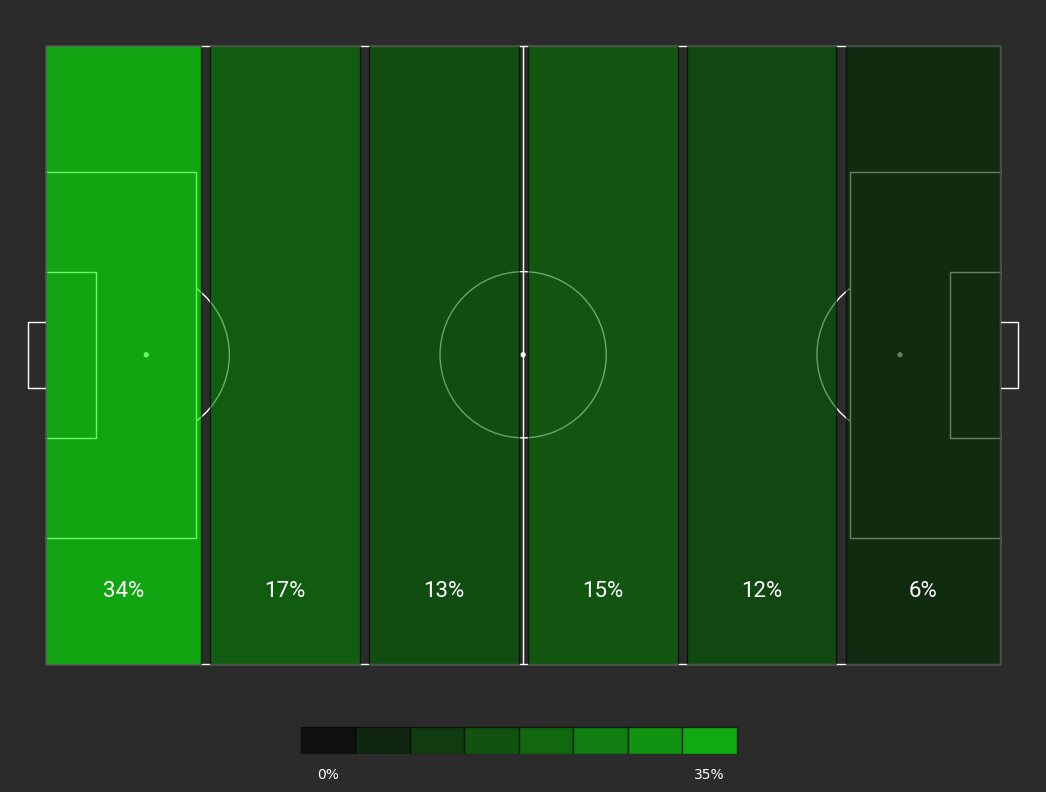

In [446]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

# Define the data for plotting
sections = ["(0.0, 17.5]", "(17.5, 35.0]", "(35.0, 52.5]", "(52.5, 70.0]", "(70.0, 87.5]", "(87.5, 105.0]"]
percentages = section_counts_percentage.values

# Determine the max value from percentages rounded up to the nearest multiple of 5
max_val = math.ceil(max(percentages) / 5) * 5

# Function to calculate green color based on percentage
def get_green_color(percentage):
    green_intensity = int((percentage / max_val) * 255)
    return f'#00{green_intensity:02x}00'

# Define pitch
pitch = Pitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Set figure and axis background color
fig.patch.set_facecolor('#2B2B2B')

gap_width = 0.5  # Width of the gap between rectangles, adjust as needed

# Add the percentage rectangles to the pitch
for i, percentage in enumerate(percentages):
    # Calculate start position for each section
    start_pos = float(sections[i].split(', ')[0][1:])
    end_pos = float(sections[i].split(', ')[1][:-1])

    # Adjust the start_pos to include the gap_width except for the first bar
    if i != 0:  # not the first bar
        start_pos += gap_width

    # Adjust the section width to account for the gap except for the last bar
    section_width = end_pos - start_pos
    if i != len(percentages) - 1:  # not the last bar
        section_width -= gap_width

    # Get the green color based on the percentage
    color = get_green_color(percentage)
    print(color)

    # Create a rectangle patch for each segment
    rect = patches.Rectangle((start_pos, 0), section_width, 68,
                             linewidth=1, edgecolor='black', facecolor=color, alpha=0.6, zorder=2)
    ax.add_patch(rect)

    # Add text label in the center of each rectangle
    ax.text(start_pos + section_width / 2, 8, str(int(percentage)) + '%', fontproperties='Roboto',
            va='center', ha='center', color='white', fontsize=16, zorder=3)

# Add the scale rectangles and text labels at the bottom of the pitch
scale_height = 3  # Reduced height of the scale rectangles by half
scale_y_position = -10  # Position of the scale rectangles (negative to be below the pitch)
scale_length = 105 / 2.5  # Half the pitch length for scale
scale_start = (105 - scale_length) / 2.25  # Centering the scale

# Create the scale based on the reduced scale length
for i in range(0, max_val + 1, 5):
    # Calculate the start position and width for each scale section
    start_pos = scale_start + (i / max_val) * scale_length
    section_width = scale_length / (max_val / 5)

    # Get the green color based on the scale value
    color = get_green_color(i)

    # Create a rectangle patch for each scale segment
    rect = patches.Rectangle((start_pos, scale_y_position), section_width, scale_height,
                             linewidth=1, edgecolor='black', facecolor=color, alpha=0.6, zorder=2)
    ax.add_patch(rect)

    if i == 0 or i == ((max_val)):
    # Add the text label for the scale value
        ax.text(start_pos + (section_width / 2), scale_y_position - (0.5*scale_height),
                f'{i}%',  # Text label for the scale percentage
                color='white',
                fontsize=10,
                ha='center', va='top',  # Center horizontally, align to the top vertically
                zorder=3)

# Adjust the limits of the axis to accommodate the scale
ax.set_ylim(bottom=-10)  # Increase the bottom limit to make space for the scale

# Show the plot
plt.show()

In [386]:
max_val

30

In [70]:
## ---------------------------------------------------------------- ##

In [ ]:
df_events['TYPE_NAME']

In [196]:
set_piece_cross_events2 = df_events[df_events['TYPE_NAME'].isin(['freekick_crossed', 'corner_crossed'])]

In [197]:
set_piece_cross_events2.reset_index(drop=True, inplace=True)

In [198]:
## Only interested in crosses that end up in the box
set_piece_cross_events2 = set_piece_cross_events2[set_piece_cross_events2['END_X'] >= 88.5]
set_piece_cross_events2 = set_piece_cross_events2[set_piece_cross_events2['END_Y'] <= 54.16]
set_piece_cross_events2 = set_piece_cross_events2[set_piece_cross_events2['END_Y'] >= 13.84]

In [199]:
## Now, we want to cateogrize each cross as a "near post", "central", or "far post" cross
""" 
If START_Y < 30.34, then:
    - Near post is where END_Y is < 30.34
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is > 37.66

If START_Y > 37.66, then:
    - Near post is where END_Y is > 37.66
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is < 30.34
"""

def classify_cross(row):
    if row['START_Y'] < 30.34:
        if row['END_Y'] < 30.34:
            return 'Near post'
        elif row['END_Y'] > 37.66:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    elif row['START_Y'] > 37.66:
        if row['END_Y'] > 37.66:
            return 'Near post'
        elif row['END_Y'] < 30.34:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    else:
        return 'Not Classified' 

In [200]:
set_piece_cross_events2['Cross_end_location'] = "NaN"
set_piece_cross_events2['Cross_end_location'] = set_piece_cross_events2.apply(classify_cross, axis=1)

In [201]:
filter_help = set_piece_cross_events2[['MATCH_ID', 'ACTION_ID']].copy()
filter_help['ACTION_ID'] += 1

In [202]:
set_piece_cross_1st_contacts = df_events.merge(filter_help, on=['MATCH_ID', 'ACTION_ID'], how='inner')

In [203]:
for index, row in filtered_matches.iterrows():
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['AWAY_TEAM_ID']
    
    inds_to_replace = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['MATCH_ID'] == row['MATCH_ID']].index
    set_piece_cross_1st_contacts.loc[inds_to_replace, 'OPPO_TEAM_ID'] = set_piece_cross_1st_contacts.loc[inds_to_replace].apply(swap_team_id, axis=1, args=(home_team_id, away_team_id))

In [204]:
for index, row in filtered_matches.iterrows():
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['AWAY_TEAM_ID']
    
    inds_to_replace = set_piece_cross_events2[set_piece_cross_events2['MATCH_ID'] == row['MATCH_ID']].index
    set_piece_cross_events2.loc[inds_to_replace, 'OPPO_TEAM_ID'] = set_piece_cross_events2.loc[inds_to_replace].apply(swap_team_id, axis=1, args=(home_team_id, away_team_id))

In [205]:
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names_2.rename({'TEAM_NAME':'OPPO_TEAM_NAME'}, axis=1),
                                                                  on="OPPO_TEAM_ID")
set_piece_cross_events2 = set_piece_cross_events2.merge(team_names_2.rename({'TEAM_NAME':'OPPO_TEAM_NAME'}, axis=1),
                                                                  on="OPPO_TEAM_ID")

In [206]:
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
set_piece_cross_events2 = set_piece_cross_events2.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [207]:
set_piece_cross_1st_contacts.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_cross_1st_contacts.reset_index(drop=True, inplace=True)

In [208]:
set_piece_cross_events2.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_cross_events2.reset_index(drop=True, inplace=True)

In [209]:
set_piece_cross_1st_contacts.shape

(3992, 17)

In [210]:
set_piece_cross_events2.shape

(3992, 18)

In [211]:
set_piece_cross_1st_contacts['Cross_end_location'] = set_piece_cross_events2['Cross_end_location']

In [212]:
set_piece_same_1st_contacts = set_piece_cross_1st_contacts[set_piece_cross_events2.TEAM_FBREF_ID == set_piece_cross_1st_contacts.TEAM_FBREF_ID]
set_piece_other_1st_contacts = set_piece_cross_1st_contacts[set_piece_cross_events2.TEAM_FBREF_ID != set_piece_cross_1st_contacts.TEAM_FBREF_ID]

In [213]:
## Those that Arsenal have lost the 1st contact
def_team_lost_1st_contact = set_piece_same_1st_contacts[set_piece_same_1st_contacts['OPPO_TEAM_NAME'] == 'Brentford']

In [214]:
## Those that Arsenal have won the 1st contact
def_team_won_1st_contact = set_piece_other_1st_contacts[set_piece_other_1st_contacts['TEAM_NAME'] == 'Brentford']

In [215]:
def_team_lost_1st_contact.value_counts('Cross_end_location')

Cross_end_location
Central      30
Far post     20
Near post     8
Name: count, dtype: int64

In [501]:
def_set_piece_final = def_team_won_1st_contact.value_counts('Cross_end_location')/(def_team_won_1st_contact.value_counts('Cross_end_location')+def_team_lost_1st_contact.value_counts('Cross_end_location'))

In [508]:
def_set_piece_final = def_set_piece_final * 100

In [510]:
def_set_piece_final

Cross_end_location
Central      74.137931
Far post     50.000000
Near post    83.673469
Name: count, dtype: float64

In [438]:
from mplsoccer import VerticalPitch

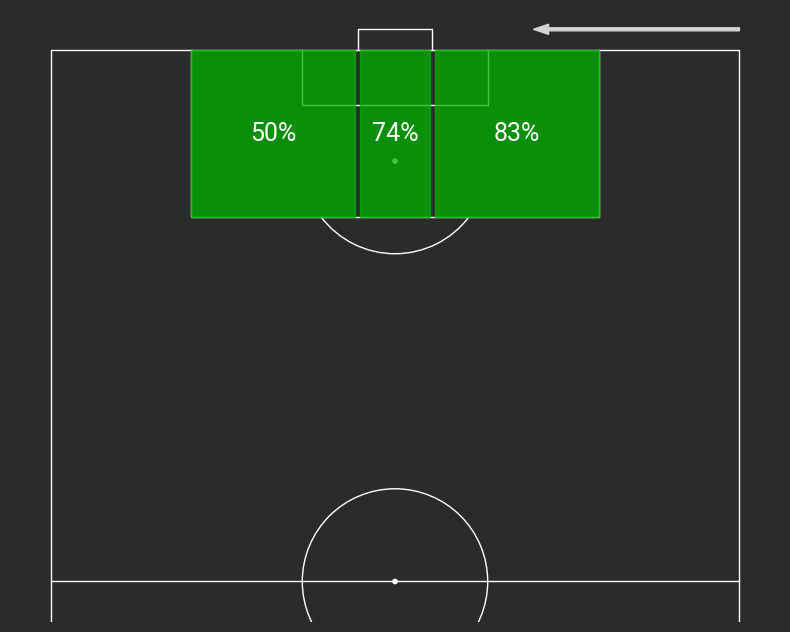

In [518]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches




# Initialize a vertical pitch
pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
fig, ax = pitch.draw(figsize=(8, 12))

# Define the coordinates for the rectangles
rect_coords = [
    [(13.84, 105), (13.84, 88.5), (30.09, 88.5), (30.09, 105)],  # Rect1
    [(30.59, 105), (30.59, 88.5), (37.41, 88.5), (37.41, 105)],  # Rect2
    [(37.91, 105), (37.91, 88.5), (54.16, 88.5), (54.16, 105)]  # Rect3
]

# Example percentages for each rectangle (use your actual values here)
percentages = [def_set_piece_final['Near post'], def_set_piece_final['Central'], def_set_piece_final['Far post']]

# Function to calculate green color based on percentage
def get_green_color(percentage, max_percentage=100):  # Assuming 100 is the max percentage
    green_intensity = int((percentage / max_percentage) * 255)
    print(f'#00{green_intensity:02x}00')
    return f'#00{green_intensity:02x}00'

# Create the rectangular patches
for i, coords in enumerate(rect_coords):
    polygon = patches.Polygon(coords, closed=True, color="#00b200", zorder=2,  alpha=0.75)
    ax.add_patch(polygon)
    
    # Add text label in the center of each rectangle
    rect_center_x = (coords[0][0] + coords[2][0]) / 2 
    rect_center_y = (coords[0][1] + coords[2][1]) / 2
    ax.text(rect_center_x, rect_center_y, f'{int(percentages[i])}%',fontproperties='Roboto',
            va='center', ha='center', color='white', fontsize=18, zorder=3)

# Set figure and axis background color
fig.patch.set_facecolor('#2B2B2B')
ax.patch.set_facecolor('#2B2B2B')

arrow_start = (0, 107)  # Adjust these values as needed for your plot
arrow_end = (18.84, 107)    # Adjust these values as needed for your plot

# Draw the arrow
ax.add_patch(patches.FancyArrow(
    arrow_start[0], arrow_start[1],  # x, y start point
    arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],  # dx, dy length
    width=0.3,  # Width of the full arrow tail
    length_includes_head=False,  # The head is included in the calculation of the arrow's length
    head_width=1,  # Width of the arrow head
    head_length=1.5,  # Length of the arrow head
    color='lightgrey'  # Light grey color
))

# Show the plot
plt.show()
